In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import json

In [13]:
# Load CSV file with annotations
csv_file = "/teamspace/studios/this_studio/Dataset_Info.csv"
data = pd.read_csv(csv_file)

# Directory where the images are stored
image_dir = "/teamspace/studios/this_studio/Dataset"

# Define color mappings for each class for visualization
class_map = {
    "Water Bodies": 0,  # Blue or assigned color in masks
    "Vegetation": 1,    # Green or assigned color in masks
    "Buildings": 2      # Red or assigned color in masks
}

In [14]:
def create_mask(image_shape, annotations):
    # Initialize a blank mask with the same height and width as the image, but single channel
    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Iterate over each annotation row
    for index, row in annotations.iterrows():
        try:
            # Parse the shape and class attributes
            region_shape = json.loads(row['region_shape_attributes'])
            region_attributes = json.loads(row['region_attributes'])

            # Determine class label from class name
            class_name = region_attributes['Name'].strip()
            label = class_map.get(class_name, 0)  # Default to 0 if class not found

            # Identify the shape type
            shape_name = region_shape['name']

            if shape_name == 'polyline':
                # Extract polyline points
                all_points_x = region_shape['all_points_x']
                all_points_y = region_shape['all_points_y']
                polyline_points = np.array(list(zip(all_points_x, all_points_y)), dtype=np.int32)
                # Draw the polyline on the mask
                cv2.polylines(mask, [polyline_points], isClosed=False, color=label, thickness=2)

            elif shape_name == 'polygon':
                # Extract polygon points
                all_points_x = region_shape['all_points_x']
                all_points_y = region_shape['all_points_y']
                polygon = np.array(list(zip(all_points_x, all_points_y)), dtype=np.int32)
                # Fill the polygon on the mask
                cv2.fillPoly(mask, [polygon], label)

            elif shape_name == 'rect':
                # Extract rectangle attributes
                x = region_shape['x']
                y = region_shape['y']
                width = region_shape['width']
                height = region_shape['height']
                # Draw a filled rectangle on the mask
                cv2.rectangle(mask, (x, y), (x + width, y + height), label, -1)

            elif shape_name == 'circle':
                # Extract circle attributes
                cx = region_shape['cx']
                cy = region_shape['cy']
                r = region_shape['r']
                # Draw a filled circle on the mask
                cv2.circle(mask, (cx, cy), r, label, -1)

            elif shape_name == 'ellipse':
                # Extract ellipse attributes
                cx = region_shape['cx']
                cy = region_shape['cy']
                rx = region_shape['rx']
                ry = region_shape['ry']
                theta = region_shape['theta']  # Angle in radians
                # Draw a filled ellipse on the mask
                cv2.ellipse(mask, (cx, cy), (rx, ry), np.degrees(theta), 0, 360, label, -1)

            else:
                print(f"Unknown shape type: {shape_name}")

        except Exception as e:
            print(f"Error in row {index}: {e}")

    return mask

In [15]:
def load_images_and_masks(data, image_dir):
    images = []
    masks = []

    # Loop through each unique image in the CSV
    for image_filename in data['filename'].unique():
        image_path = os.path.join(image_dir, image_filename)
        if os.path.exists(image_path):
            # Read the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, (512, 512))  # Ensure all images are 512x512

            # Get corresponding annotations for this image
            image_annotations = data[data['filename'] == image_filename]

            # Create mask from annotations
            mask = create_mask(image.shape, image_annotations)

            # Append image and mask to lists
            images.append(image)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Load images and masks
images, masks = load_images_and_masks(data, image_dir)

# Normalize the images and one-hot encode the masks for CNN training
images = images / 255.0  # Normalize image data

# One-hot encode masks to match model output for semantic segmentation
num_classes = len(class_map)
masks_one_hot = tf.keras.utils.to_categorical(masks, num_classes=num_classes)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks_one_hot, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

# Define class weights for loss function
class_weights = np.array([2.0, 1.0, 2.5])  # Weights for Water Bodies, Vegetation, Buildings

Training set: (306, 512, 512, 3), (306, 512, 512, 3)
Validation set: (77, 512, 512, 3), (77, 512, 512, 3)


In [16]:
# Define SegNet model for semantic segmentation
def segnet_model(input_shape=(512, 512, 3), num_classes=3):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder
    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    
    # Decoder
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [17]:
# Compile and train the model
model = segnet_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=8)

model.save("/teamspace/studios/this_studio/Dataset/SegNet.h5")
print("Model saved successfully!")

Epoch 1/20
39/39 [==============================] - 128s 3s/step - loss: 0.9911 - accuracy: 0.4892 - val_loss: 0.8266 - val_accuracy: 0.6267
Epoch 2/20
39/39 [==============================] - 127s 3s/step - loss: 0.9034 - accuracy: 0.4731 - val_loss: 0.8227 - val_accuracy: 0.6267
Epoch 3/20
39/39 [==============================] - 127s 3s/step - loss: 0.8357 - accuracy: 0.5628 - val_loss: 0.7650 - val_accuracy: 0.6037
Epoch 4/20
39/39 [==============================] - 127s 3s/step - loss: 0.7968 - accuracy: 0.6061 - val_loss: 0.7397 - val_accuracy: 0.6169
Epoch 5/20
39/39 [==============================] - 127s 3s/step - loss: 0.7934 - accuracy: 0.5867 - val_loss: 0.7714 - val_accuracy: 0.5408
Epoch 6/20
39/39 [==============================] - 127s 3s/step - loss: 0.7775 - accuracy: 0.6090 - val_loss: 0.7262 - val_accuracy: 0.6095
Epoch 7/20
39/39 [==============================] - 127s 3s/step - loss: 0.7749 - accuracy: 0.6121 - val_loss: 0.7468 - val_accuracy: 0.6301
Epoch 8/20
39

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, accuracy_score, f1_score
import pandas as pd

# Define IoU (Jaccard Score) and Dice Coefficient calculation functions
def calculate_iou(y_true, y_pred, num_classes=3):
    ious = []
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    for i in range(num_classes):
        intersection = np.sum((y_true_flat == i) & (y_pred_flat == i))
        union = np.sum((y_true_flat == i) | (y_pred_flat == i))
        iou = intersection / union if union != 0 else 0
        ious.append(iou)
    
    return np.mean(ious)

def calculate_dice(y_true, y_pred, num_classes=3):
    dice_scores = []
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    for i in range(num_classes):
        intersection = np.sum((y_true_flat == i) & (y_pred_flat == i))
        dice = (2 * intersection) / (np.sum(y_true_flat == i) + np.sum(y_pred_flat == i))
        dice_scores.append(dice)
    
    return np.mean(dice_scores)

# Run predictions on the validation set
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_val, axis=-1)

# Calculate IoU (Jaccard), Dice Coefficient, and Pixel Accuracy
iou = calculate_iou(y_true, y_pred, num_classes=num_classes)
dice = calculate_dice(y_true, y_pred, num_classes=num_classes)
pixel_accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
f1 = f1_score(y_true.flatten(), y_pred.flatten(), average="macro")

# Display metrics in a table
metrics_data = {
    "Metric": ["IoU (Jaccard Score)", "Dice Coefficient", "Pixel Accuracy", "F1 Score"],
    "Score": [iou, dice, pixel_accuracy, f1]
}
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

# Display metrics as a table
print("Performance Metrics Table:")
display(metrics_df)

3/3 [==============================] - 11s 3s/step
                Metric     Score
0  IoU (Jaccard Score)  0.290616
1     Dice Coefficient  0.402930
2       Pixel Accuracy  0.604537
3             F1 Score  0.402930
Performance Metrics Table:


,Metric,Score
0,IoU (Jaccard Score),0.290616
1,Dice Coefficient,0.402930
2,Pixel Accuracy,0.604537
3,F1 Score,0.402930


1/1 [==============================] - 0s 242ms/step
Class counts in prediction: {0: 120404, 1: 141740}


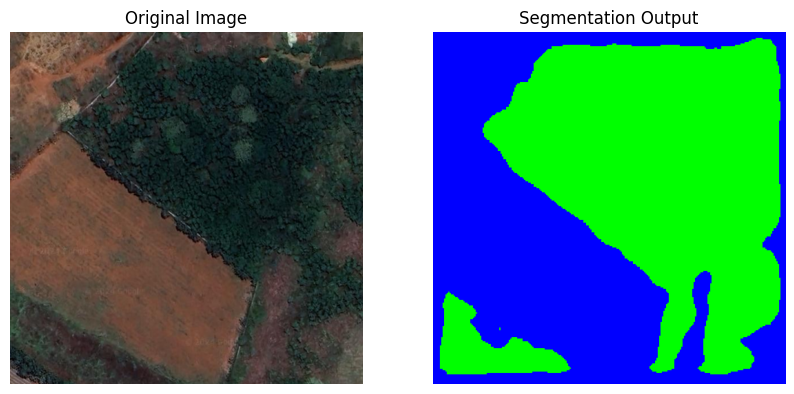

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the pre-trained model
model_path = "/teamspace/studios/this_studio/Dataset/SegNet.h5" # Replace with the actual model path
model = load_model(model_path)

# Define colors for each class
color_map = {
    0: (0, 0, 255),   # Red for Water Bodies
    1: (0, 255, 0),   # Green for Vegetation
    2: (255, 0, 0)    # Blue for Buildings
}

def predict_and_visualize(image, model):
    if image is None:
        print("Error: Image not loaded. Check the file path.")
        return
    
    # Preprocess the image (resize and normalize)
    input_image = cv2.resize(image, (512, 512))
    input_image = input_image / 255.0
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

    # Generate predictions
    predictions = model.predict(input_image)
    
    # Ensure predictions are in the expected shape
    if predictions.shape[-1] != 3:
        print("Error: Model output does not have 3 channels (one for each class). Check model architecture.")
        return
    
    # Get class labels for each pixel
    predicted_mask = np.argmax(predictions[0], axis=-1)  # Convert to class labels
    
    # Display unique classes in the prediction for debugging
    unique_classes, class_counts = np.unique(predicted_mask, return_counts=True)
    print("Class counts in prediction:", dict(zip(unique_classes, class_counts)))

    # Create a color overlay based on predicted classes
    color_overlay = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        color_overlay[predicted_mask == class_id] = color

    # Display the original image and segmentation overlay side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[1].imshow(color_overlay)
    axs[1].set_title("Segmentation Output")
    for ax in axs:
        ax.axis("off")
    plt.show()

# Load the uploaded image
test_image_path = "/teamspace/studios/this_studio/Dataset/26.png" # Path to the uploaded image
test_image = cv2.imread(test_image_path)

# Run prediction and visualization
predict_and_visualize(test_image, model)

1/1 [==============================] - 0s 252ms/step
Class counts in prediction: {0: 153436, 1: 108708}


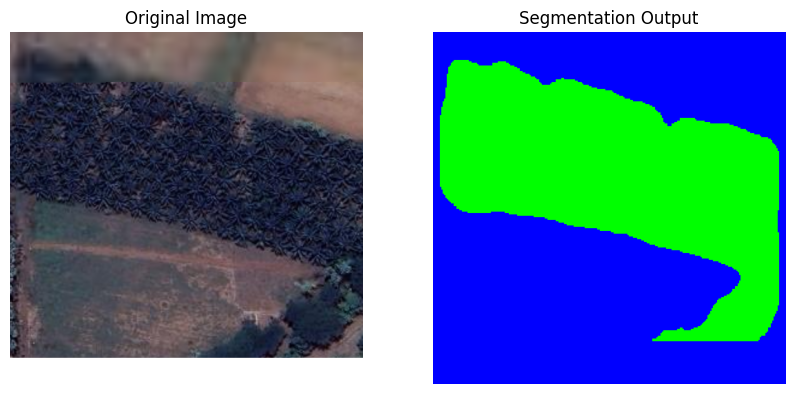

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the pre-trained model
model_path = "/teamspace/studios/this_studio/Dataset/SegNet.h5" # Replace with the actual model path
model = load_model(model_path)

# Define colors for each class
color_map = {
    0: (0, 0, 255),   # Red for Water Bodies
    1: (0, 255, 0),   # Green for Vegetation
    2: (255, 0, 0)    # Blue for Buildings
}

def predict_and_visualize(image, model):
    if image is None:
        print("Error: Image not loaded. Check the file path.")
        return
    
    # Preprocess the image (resize and normalize)
    input_image = cv2.resize(image, (512, 512))
    input_image = input_image / 255.0
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

    # Generate predictions
    predictions = model.predict(input_image)
    
    # Ensure predictions are in the expected shape
    if predictions.shape[-1] != 3:
        print("Error: Model output does not have 3 channels (one for each class). Check model architecture.")
        return
    
    # Get class labels for each pixel
    predicted_mask = np.argmax(predictions[0], axis=-1)  # Convert to class labels
    
    # Display unique classes in the prediction for debugging
    unique_classes, class_counts = np.unique(predicted_mask, return_counts=True)
    print("Class counts in prediction:", dict(zip(unique_classes, class_counts)))

    # Create a color overlay based on predicted classes
    color_overlay = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        color_overlay[predicted_mask == class_id] = color

    # Display the original image and segmentation overlay side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[1].imshow(color_overlay)
    axs[1].set_title("Segmentation Output")
    for ax in axs:
        ax.axis("off")
    plt.show()

# Load the uploaded image
test_image_path = "/teamspace/studios/this_studio/Dataset/34.png" # Path to the uploaded image
test_image = cv2.imread(test_image_path)

# Run prediction and visualization
predict_and_visualize(test_image, model)